# Monti Carlo Simulation (PSKY) - Parametric Method
Calculating Value at Risk over a longer period

#### Quarterly Value at Risk

For a $1Mil position on PSKY, simulate the minimum loss over a period of one quarter that will occur with 1% probability: 1% VaR of $1M USD over a period of one quarter (63 business days). Use the parametric method

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn-v0_8")

In [2]:
class FinancialInstrument():
    ''' Class for analyzing Financial Instruments like stocks.

    Attributes
    ==========
    ticker: str
        ticker symbol with which to work with
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval

    Methods
    =======
    get_data:
        retrieves daily price data (from yahoo finance) and prepares the data
    log_returns:
        calculates log returns
    plot_prices:
        creates a price chart
    plot_returns:
        plots log returns either as time series ("ts") or histogram ("hist")
    set_ticker:
        sets a new ticker
    mean_return:
        calculates mean return
    std_returns:
        calculates the standard deviation of returns (risk)
    annualized_perf:
        calculates annulized return and risk
    '''
    
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.get_data()
        self.log_returns()
    
    def __repr__(self): 
        return "FinancialInstrument(ticker = {}, start = {}, end = {})".format(self.ticker, 
                                                                               self.start, self.end)
    def get_data(self):
        ''' retrieves (from yahoo finance) and prepares the data
        '''
        raw = yf.download(self.ticker, self.start, self.end, multi_level_index = False).Close.to_frame() # new from yfinance 0.2.48
        raw.rename(columns = {"Close":"price"}, inplace = True)
        self.data = raw
        
    def log_returns(self):
        '''calculates log returns
        '''
        self.data["log_returns"] = np.log(self.data.price/self.data.price.shift(1))
        
    def plot_prices(self):
        ''' creates a price chart
        '''
        self.data.price.plot(figsize = (12, 8))
        plt.title("Price Chart: {}".format(self.ticker), fontsize = 15)
    
    def plot_returns(self, kind = "ts"):
        ''' plots log returns either as time series ("ts") or histogram ("hist")
        '''
        if kind == "ts":
            self.data.log_returns.plot(figsize = (12, 8))
            plt.title("Returns: {}".format(self.ticker), fontsize = 15)
        elif kind == "hist":
            self.data.log_returns.hist(figsize = (12, 8), bins = int(np.sqrt(len(self.data))))
            plt.title("Frequency of Returns: {}".format(self.ticker), fontsize = 15)
    
    def set_ticker(self, ticker = None):
        '''sets a new ticker
        '''
        if ticker is not None:
            self.ticker = ticker
            self.get_data()
            self.log_returns()
            
    def mean_return(self, freq = None):
        '''calculates mean return
        '''
        if freq is None:
            return self.data.log_returns.mean()
        else:
            resampled_price = self.data.price.resample(freq).last()
            resampled_returns = np.log(resampled_price / resampled_price.shift(1))
            return resampled_returns.mean()
    
    def std_returns(self, freq = None):
        '''calculates the standard deviation of returns (risk)
        '''
        if freq is None:
            return self.data.log_returns.std()
        else:
            resampled_price = self.data.price.resample(freq).last()
            resampled_returns = np.log(resampled_price / resampled_price.shift(1))
            return resampled_returns.std()
        
    def annualized_perf(self):
        '''calculates annulized return and risk
        '''
        mean_return = round(self.data.log_returns.mean() * 252, 3)
        risk = round(self.data.log_returns.std() * np.sqrt(252), 3)
        print("Return: {} | Risk: {}".format(mean_return, risk))

In [3]:
stock = FinancialInstrument(ticker = "PSKY", start = "2000-07-01", 
                            end =  "2025-12-31" ) # instantiation

[*********************100%***********************]  1 of 1 completed


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
np.set_printoptions(precision=4, suppress=True)

#### Returns

In [5]:
returns = stock.data.log_returns.dropna().values

In [6]:
returns

array([-0.0358, -0.0082, -0.0063, ..., -0.0059,  0.0154, -0.011 ],
      shape=(5046,))

In [7]:
returns.size

5046

In [9]:
mean = returns.mean()
mean

np.float64(-4.3198088424558564e-05)

In [10]:
std = returns.std()
std

np.float64(0.029086625468600722)

In [28]:
IO = 100  # Initial Investment
size = int(252/4)    # Time Horizon (days per quarter)

In [29]:
size

63

#### One simulation/path

In [30]:
np.random.seed(123)  # for reproducibility
ret = np.random.normal(loc=mean, scale=std, size=size)
ret

array([-0.0316,  0.029 ,  0.0082, -0.0439, -0.0169,  0.048 , -0.0706,
       -0.0125,  0.0368, -0.0253, -0.0198, -0.0028,  0.0433, -0.0186,
       -0.013 , -0.0127,  0.0641,  0.0636,  0.0292,  0.0112,  0.0214,
        0.0433, -0.0273,  0.0342, -0.0365, -0.0186,  0.0263, -0.0416,
       -0.0041, -0.0251, -0.0075, -0.0814, -0.0516, -0.0204,  0.0269,
       -0.0051,  0.    ,  0.02  , -0.0256,  0.0082, -0.0235, -0.0503,
       -0.0114,  0.0166,  0.0098, -0.0004,  0.0695,  0.012 ,  0.0284,
        0.0651, -0.0377, -0.0303,  0.0507, -0.0233,  0.0008,  0.0311,
        0.0259,  0.051 ,  0.0435,  0.0311, -0.0225,  0.0231,  0.0091])

In [31]:
# Simulate price path
path = (ret + 1).cumprod() * IO
path

array([ 96.8379,  99.643 , 100.4588,  96.0531,  94.4324,  98.9644,
        91.9748,  90.8234,  94.1637,  91.7857,  89.9693,  89.7176,
        93.6056,  91.8621,  90.6718,  89.5223,  95.2625, 101.3177,
       104.2722, 105.439 , 107.6959, 112.3609, 109.2976, 113.031 ,
       108.9037, 106.8788, 109.6942, 105.131 , 104.6982, 102.0693,
       101.306 ,  93.0552,  88.2562,  86.4558,  88.7843,  88.3321,
        88.3356,  90.1001,  87.7912,  88.5117,  86.4344,  82.0872,
        81.1503,  82.5012,  83.3101,  83.2779,  89.0692,  90.1351,
        92.6972,  98.7278,  95.0074,  92.1326,  96.8015,  94.5503,
        94.6278,  97.5669, 100.0904, 105.1951, 109.7669, 113.1764,
       110.6279, 113.1808, 114.2105])

In [32]:
# include initial investment
path = np.insert(path, 0, IO)
path

array([100.    ,  96.8379,  99.643 , 100.4588,  96.0531,  94.4324,
        98.9644,  91.9748,  90.8234,  94.1637,  91.7857,  89.9693,
        89.7176,  93.6056,  91.8621,  90.6718,  89.5223,  95.2625,
       101.3177, 104.2722, 105.439 , 107.6959, 112.3609, 109.2976,
       113.031 , 108.9037, 106.8788, 109.6942, 105.131 , 104.6982,
       102.0693, 101.306 ,  93.0552,  88.2562,  86.4558,  88.7843,
        88.3321,  88.3356,  90.1001,  87.7912,  88.5117,  86.4344,
        82.0872,  81.1503,  82.5012,  83.3101,  83.2779,  89.0692,
        90.1351,  92.6972,  98.7278,  95.0074,  92.1326,  96.8015,
        94.5503,  94.6278,  97.5669, 100.0904, 105.1951, 109.7669,
       113.1764, 110.6279, 113.1808, 114.2105])

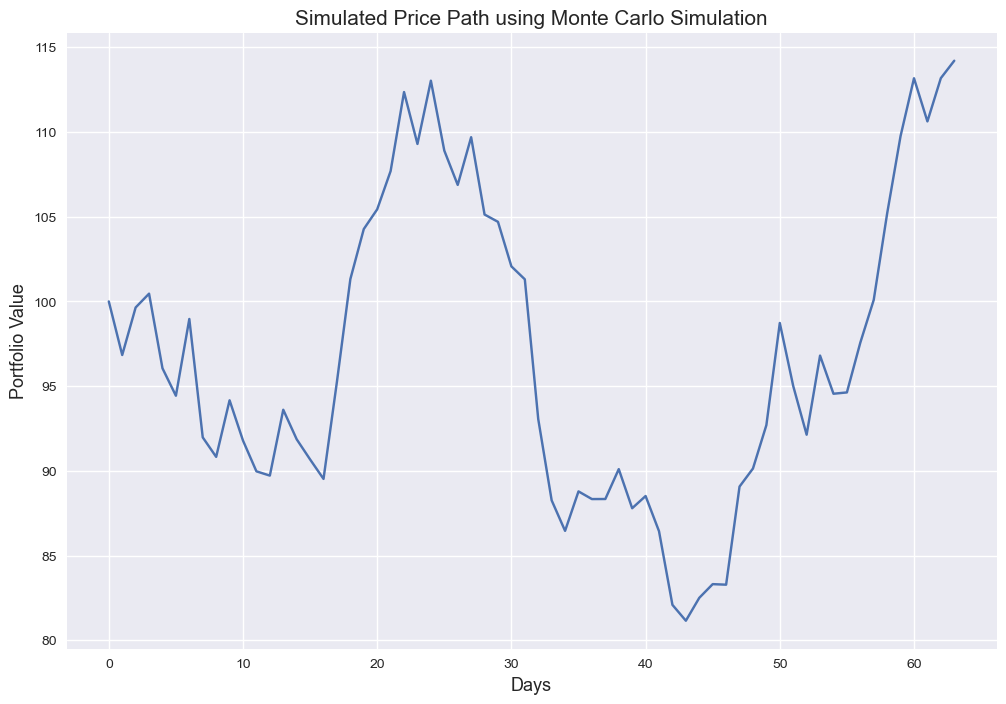

In [33]:
# plot the simulated price path
plt.figure(figsize=(12, 8))
plt.plot(path)
plt.title("Simulated Price Path using Monte Carlo Simulation", fontsize=15)
plt.xlabel("Days", fontsize=13)
plt.ylabel("Portfolio Value", fontsize=13)
plt.grid(True)
plt.show()

#### Many simulations/path

In [34]:
sims = 10000
days = 63  # 1 quarter (252 trading days / 4)

In [35]:
np.random.seed(123)  # for reproducibility
ret = np.random.normal(loc=mean, scale=std, size=(days * sims)).reshape(sims, days)

In [36]:
ret.shape

(10000, 63)

In [37]:
ret

array([[-0.0316,  0.029 ,  0.0082, ..., -0.0225,  0.0231,  0.0091],
       [-0.0386,  0.0412,  0.0234, ...,  0.0217,  0.0467, -0.0079],
       [ 0.0236,  0.0145,  0.0138, ..., -0.016 , -0.0285, -0.0104],
       ...,
       [-0.0328, -0.0595, -0.0254, ..., -0.0396, -0.0089,  0.0157],
       [-0.0471, -0.0342,  0.0235, ...,  0.036 , -0.0217, -0.0084],
       [ 0.0123,  0.0239, -0.0341, ...,  0.0045,  0.0536,  0.0207]],
      shape=(10000, 63))

In [38]:
paths = (ret + 1).cumprod(axis=1) * IO
paths

array([[ 96.8379,  99.643 , 100.4588, ..., 110.6279, 113.1808, 114.2105],
       [ 96.138 , 100.0971, 102.443 , ...,  86.2234,  90.2542,  89.5409],
       [102.3585, 103.8419, 105.2702, ..., 104.0292, 101.0653, 100.0178],
       ...,
       [ 96.7171,  90.9638,  88.6557, ...,  79.5703,  78.8599,  80.0944],
       [ 95.2854,  92.0249,  94.1883, ..., 116.2122, 113.6928, 112.7328],
       [101.2334, 103.6575, 100.1204, ..., 134.493 , 141.6969, 144.6253]],
      shape=(10000, 63))

In [39]:
paths = np.hstack((np.ones(sims).reshape(sims, 1)*100, paths))
paths

array([[100.    ,  96.8379,  99.643 , ..., 110.6279, 113.1808, 114.2105],
       [100.    ,  96.138 , 100.0971, ...,  86.2234,  90.2542,  89.5409],
       [100.    , 102.3585, 103.8419, ..., 104.0292, 101.0653, 100.0178],
       ...,
       [100.    ,  96.7171,  90.9638, ...,  79.5703,  78.8599,  80.0944],
       [100.    ,  95.2854,  92.0249, ..., 116.2122, 113.6928, 112.7328],
       [100.    , 101.2334, 103.6575, ..., 134.493 , 141.6969, 144.6253]],
      shape=(10000, 64))

In [40]:
def path_simul_param(daily_returns, days, IO, sims = 10000, seed = 123):
    
    mean = np.mean(daily_returns)
    std = np.std(daily_returns)
    days = int(days)

    np.random.seed(seed)  # for reproducibility
    ret = np.random.normal(loc=mean, scale=std, size=(days * sims)).reshape(sims, days)

    paths = (ret + 1).cumprod(axis=1) * IO
    paths = np.hstack((np.ones(sims).reshape(sims, 1)*IO, paths))

    return paths

In [41]:
paths = path_simul_param(daily_returns=returns, days=63, IO=100)

In [42]:
paths

array([[100.    ,  96.8379,  99.643 , ..., 110.6279, 113.1808, 114.2105],
       [100.    ,  96.138 , 100.0971, ...,  86.2234,  90.2542,  89.5409],
       [100.    , 102.3585, 103.8419, ..., 104.0292, 101.0653, 100.0178],
       ...,
       [100.    ,  96.7171,  90.9638, ...,  79.5703,  78.8599,  80.0944],
       [100.    ,  95.2854,  92.0249, ..., 116.2122, 113.6928, 112.7328],
       [100.    , 101.2334, 103.6575, ..., 134.493 , 141.6969, 144.6253]],
      shape=(10000, 64))

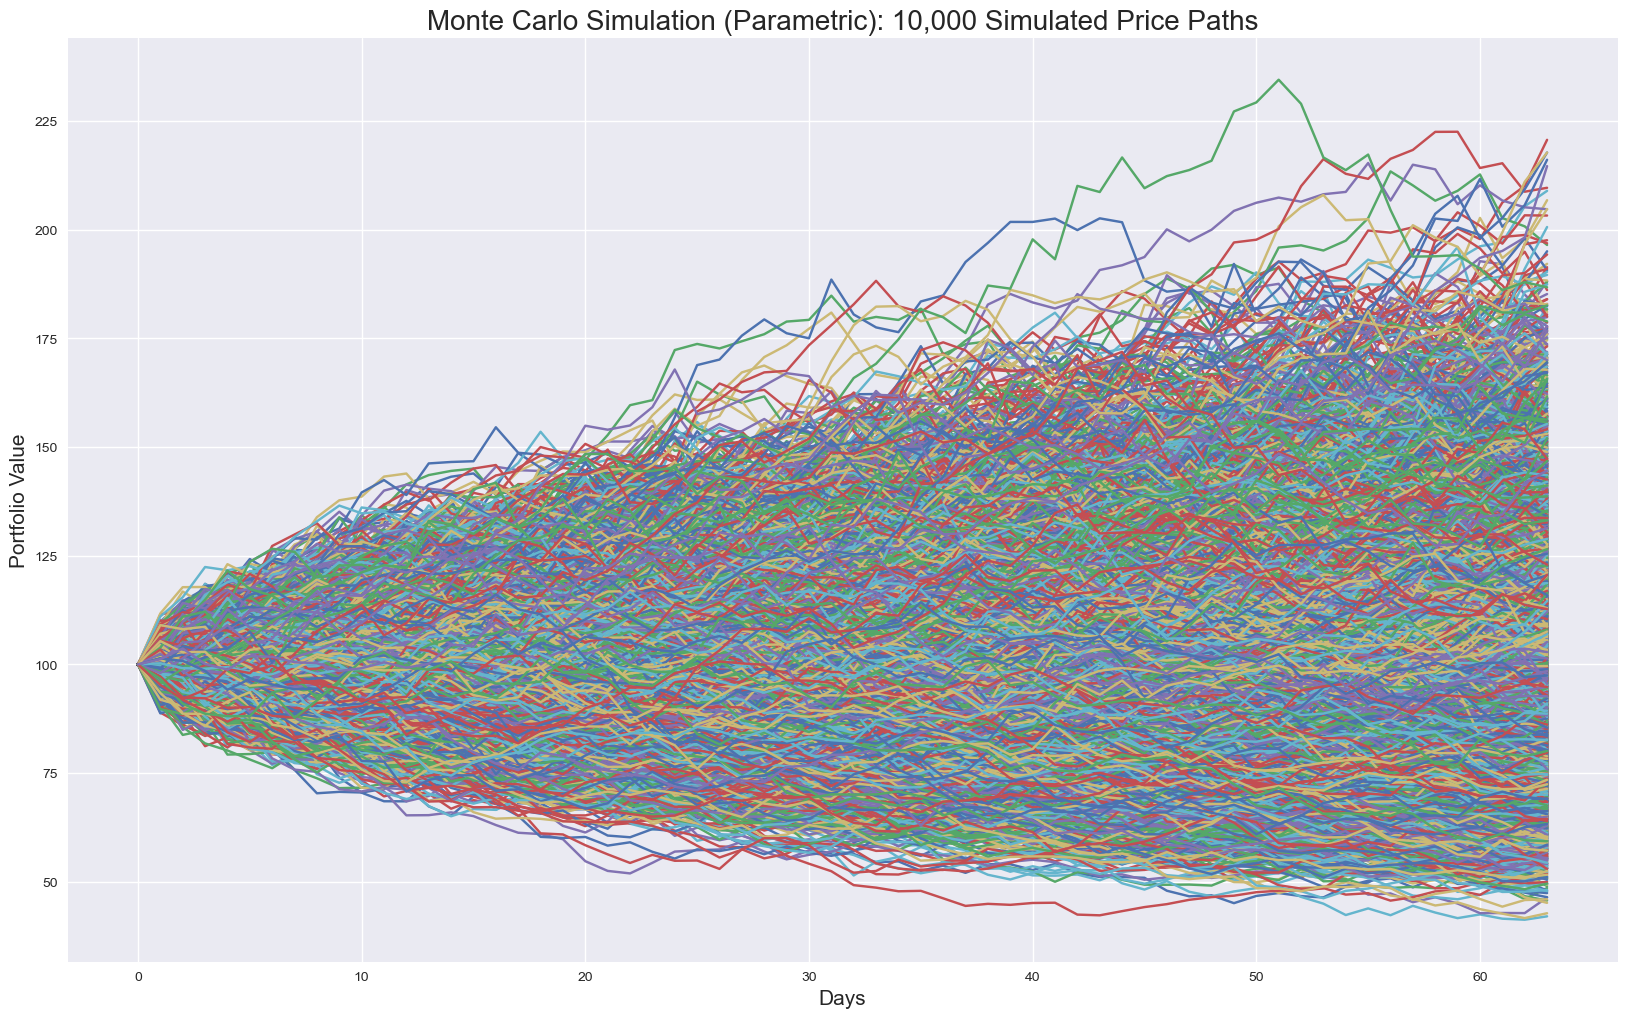

In [44]:
plt.figure(figsize=(20, 12))
plt.plot(paths.T)
plt.title("Monte Carlo Simulation (Parametric): 10,000 Simulated Price Paths", fontsize=20)
plt.xlabel("Days", fontsize=15)
plt.ylabel("Portfolio Value", fontsize=15)
#plt.grid(True)
plt.show()

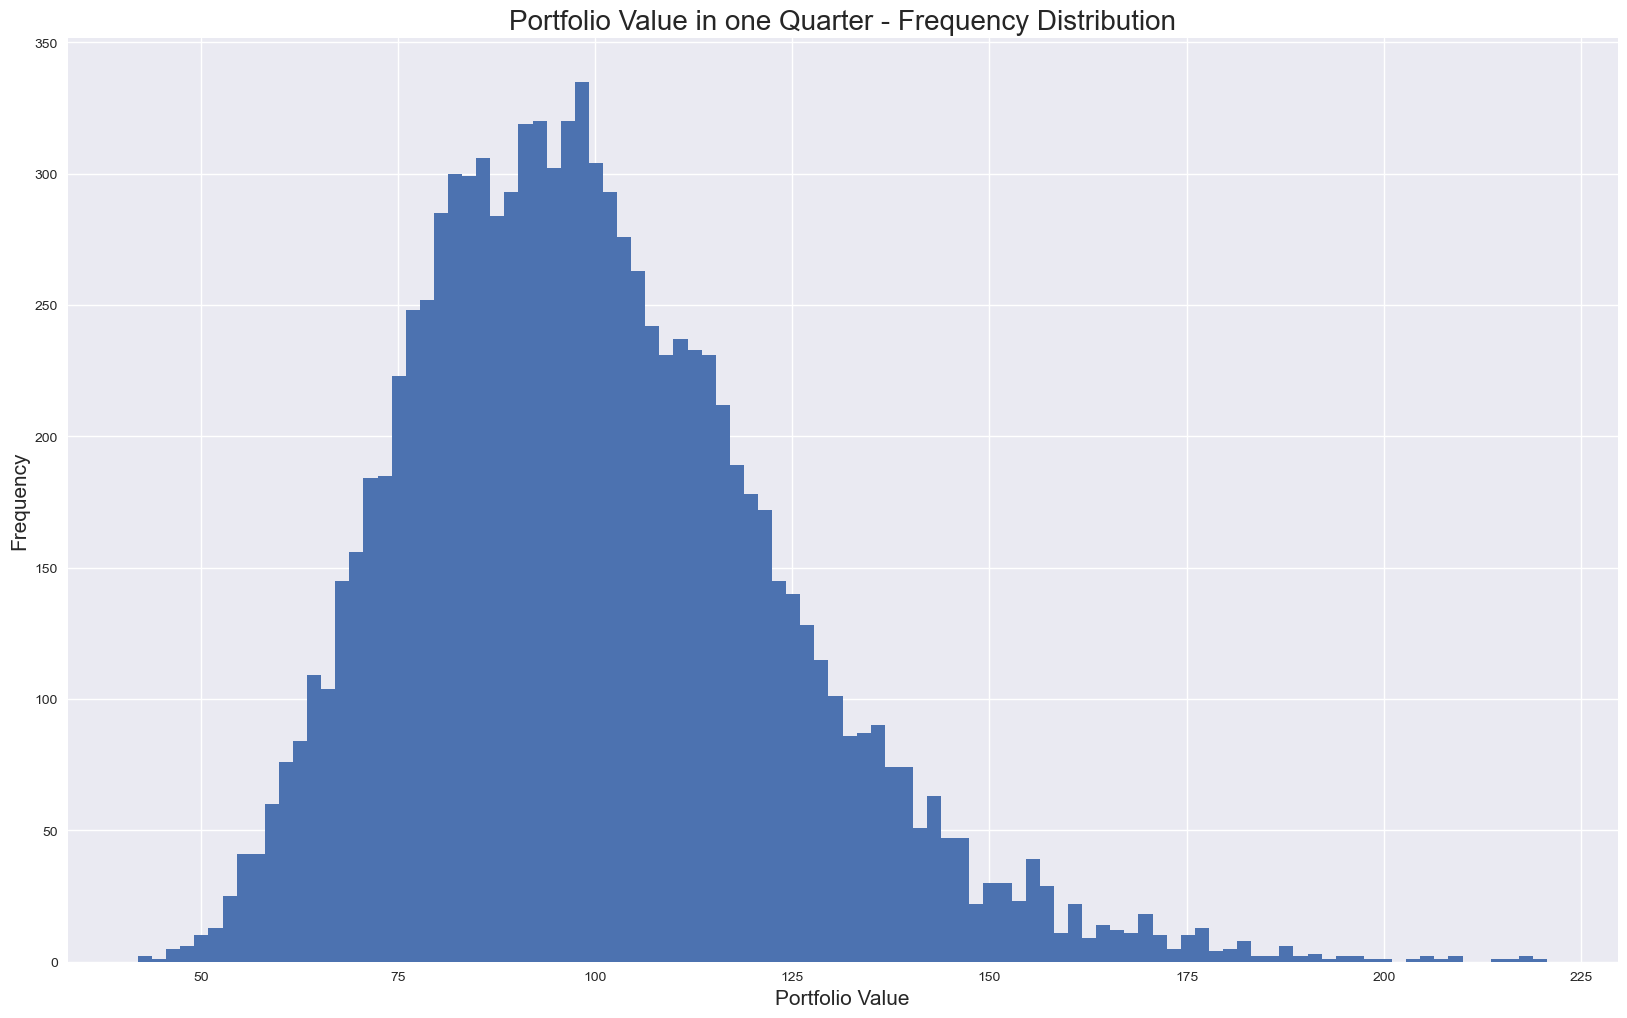

In [45]:
plt.figure(figsize=(20, 12))
plt.hist(paths[:, -1], bins=100)
plt.title("Portfolio Value in one Quarter - Frequency Distribution", fontsize=20)
plt.xlabel("Portfolio Value", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

#### VaR for $1M USD Portfolio of PSKY

In [46]:
sims = 1000000
IO = 1000000

In [47]:
paths = path_simul_param(returns, days=63, IO=IO, sims=sims)

In [48]:
paths.shape

(1000000, 64)

In [49]:
# final portfolio values
final_p = paths[:, -1]

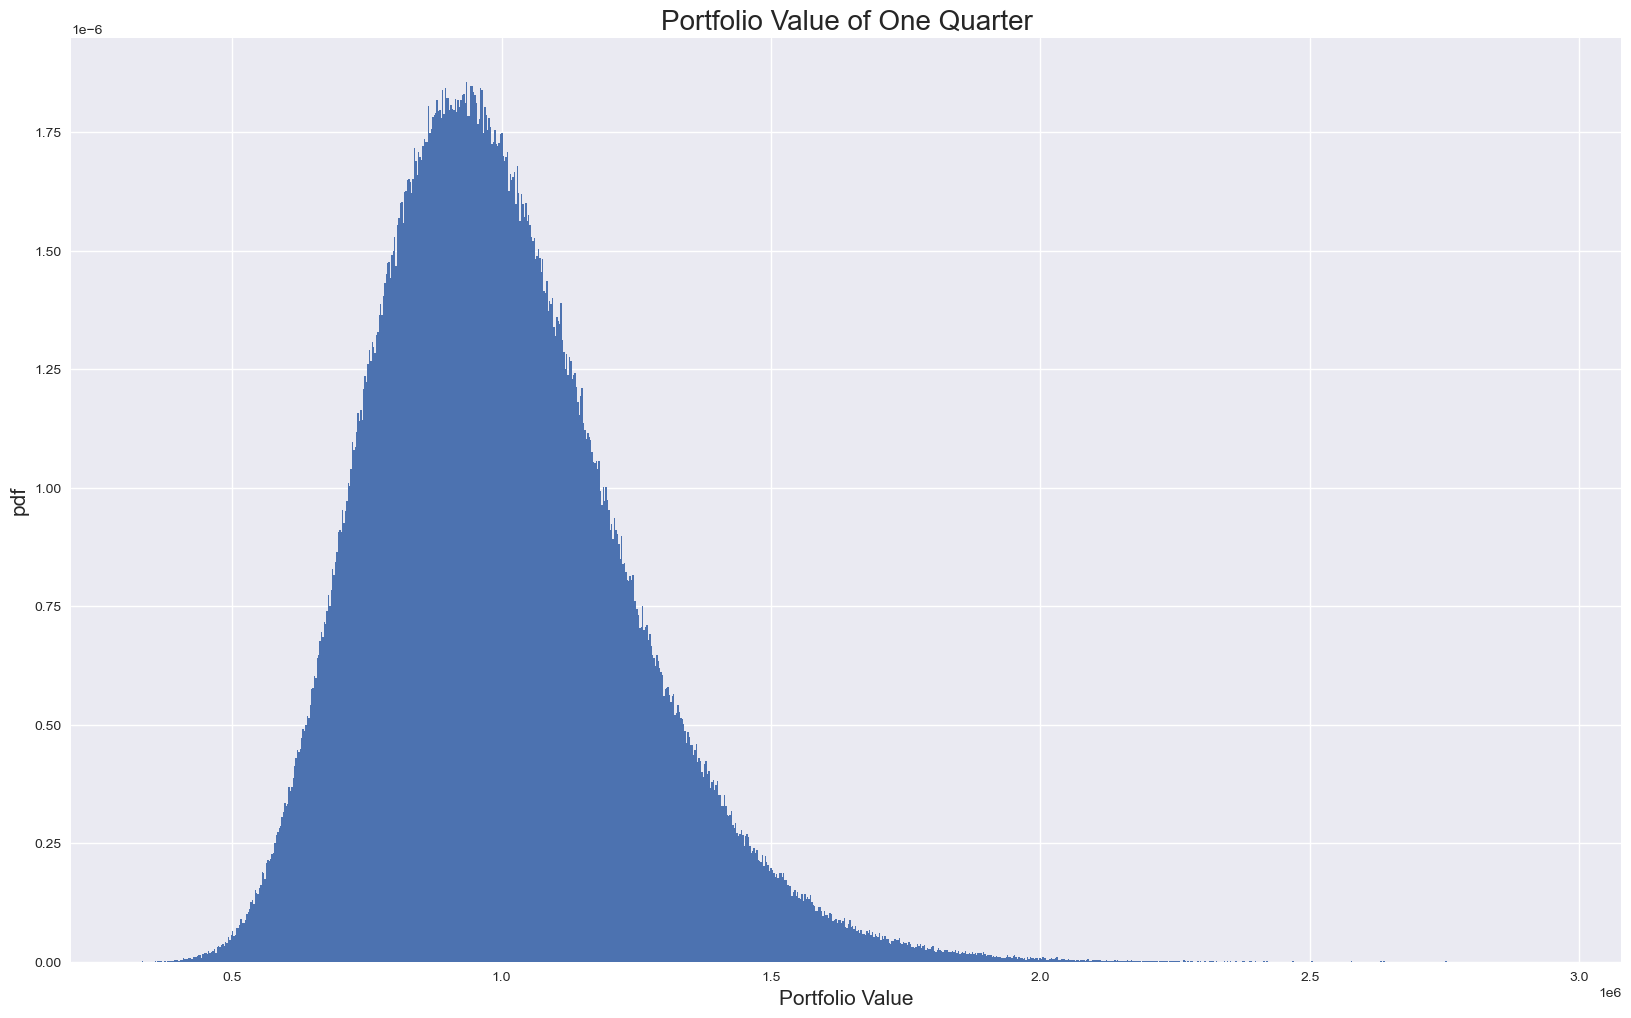

In [50]:
plt.figure(figsize=(20, 12))
plt.hist(final_p, bins=1000, density=True)
plt.title("Portfolio Value of One Quarter", fontsize=20)
plt.xlabel("Portfolio Value", fontsize=15)
plt.ylabel("pdf", fontsize=15)
#plt.grid(True)
plt.show()

In [51]:
# mean value of the final portfolio values
final_p.mean()

np.float64(997704.7580795157)

In [52]:
np.median(final_p)

np.float64(971664.2290974567)

In [53]:
final_p.std()

np.float64(233640.4089260832)

In [54]:
stats.skew(final_p)

np.float64(0.7079063865741633)

#### 1% Valeu-at-Risk (VaR) of $1,000,000 USD over a period of one quarter

In [55]:
prob = 0.01

In [56]:
np.percentile(final_p, prob*100)

np.float64(566046.847502749)

In [57]:
np.percentile(final_p, prob*100) - IO

np.float64(-433953.15249725105)

VaR of -$433,953 USD 

In [ ]:
# Value at Risk (VaR) function
def var_param(daily_returns, days, IO, prob, sims=10000, seed=123):

    mean = np.mean(daily_returns)
    std = np.std(daily_returns)
    days = int(days)

    np.random.seed(seed)  # for reproducibility
    ret = np.random.normal(loc=mean, scale=std, size=(days * sims)).reshape(sims, days)

    final = (ret + 1).prod(axis=1) * IO
    var = np.percentile(final, prob) - IO

    return var

In [ ]:
# daily Value at Risk (VaR)
var_param(returns, days=1, IO=1000000, prob=1, sims=1000000)

np.float64(-67737.59767864889)

In [ ]:
# quarterly Value at Risk (VaR)
var_param(returns, days=63, IO=1000000, prob=1, sims=1000000)

np.float64(-433953.15249725105)

In [62]:
# VaR from 1 day to 365 days (252 trading days)
var_p1 = [] 
for i in range(1, 252+1):
    var_p1.append(-var_param(returns, days=i, IO=1000000, prob=1))

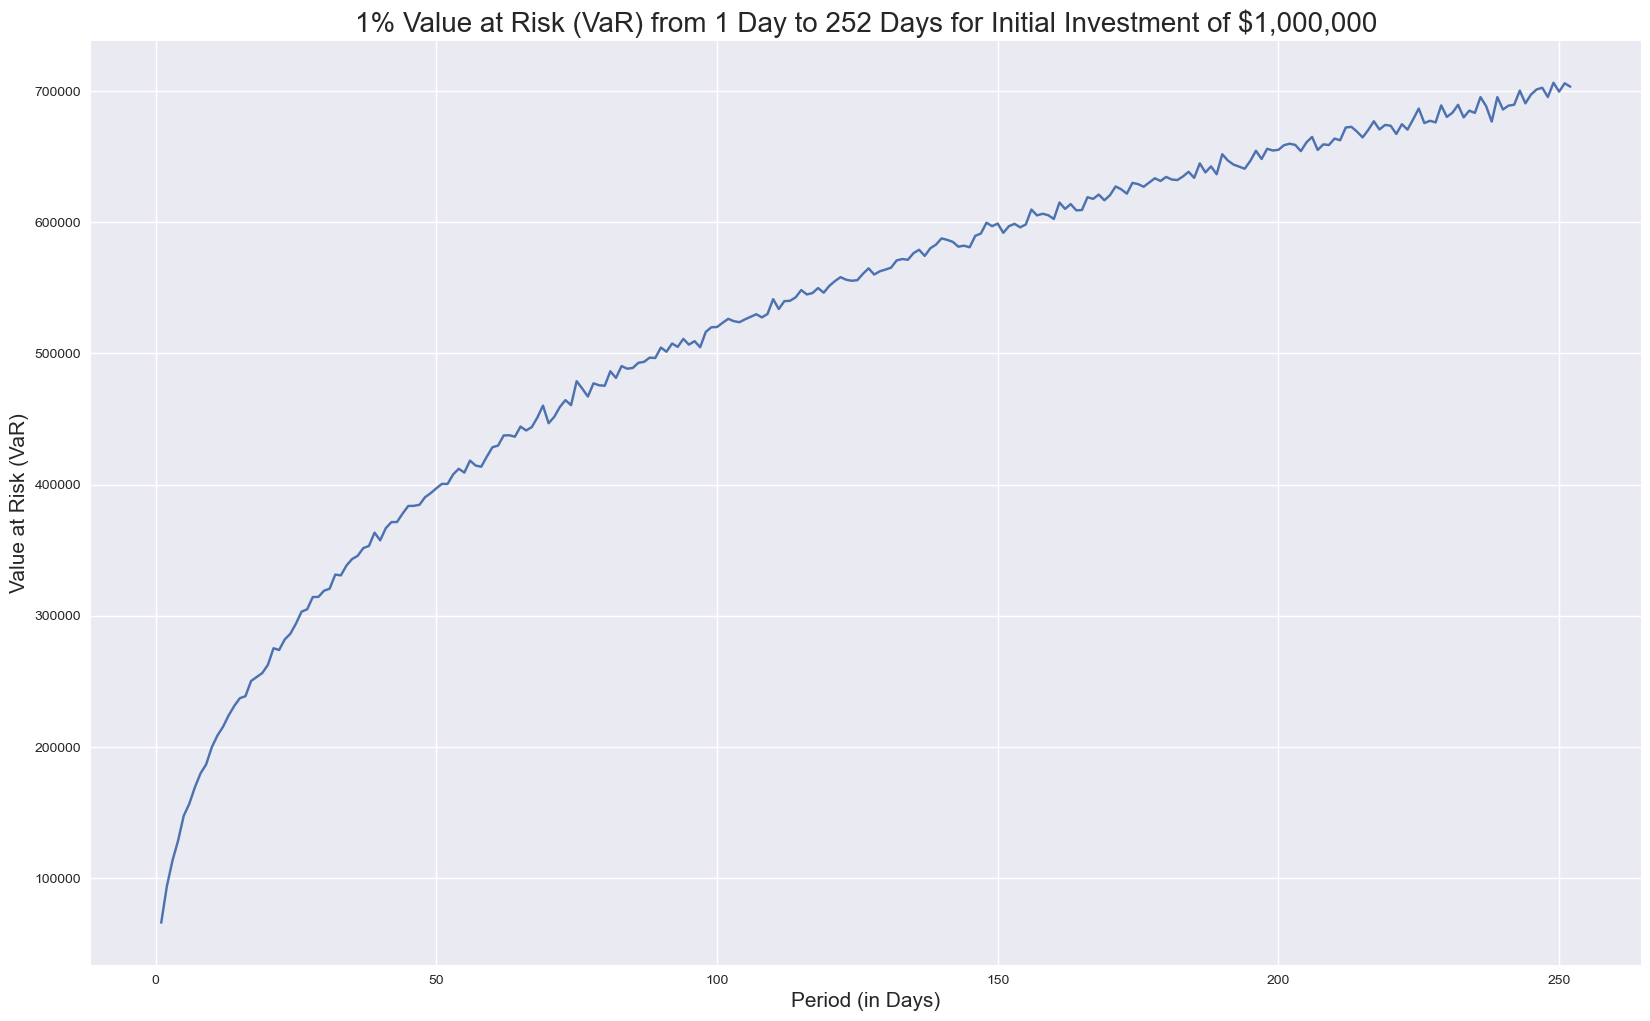

In [64]:
plt.figure(figsize=(20, 12))
plt.plot(range(1, 252+1), var_p1)
plt.title("1% Value at Risk (VaR) from 1 Day to 252 Days for Initial Investment of $1,000,000",
          fontsize=20)
plt.xlabel("Period (in Days)", fontsize=15)
plt.ylabel("Value at Risk (VaR)", fontsize=15)
#plt.grid(True)
plt.show()

In [66]:
# VaR between 0.1% and 5% for 1 quarter (63 days)
var_p2 = []
for i in np.linspace(0.1, 5, 50):
    var_p2.append(-var_param(returns, days=63, IO=1000000, prob=i))


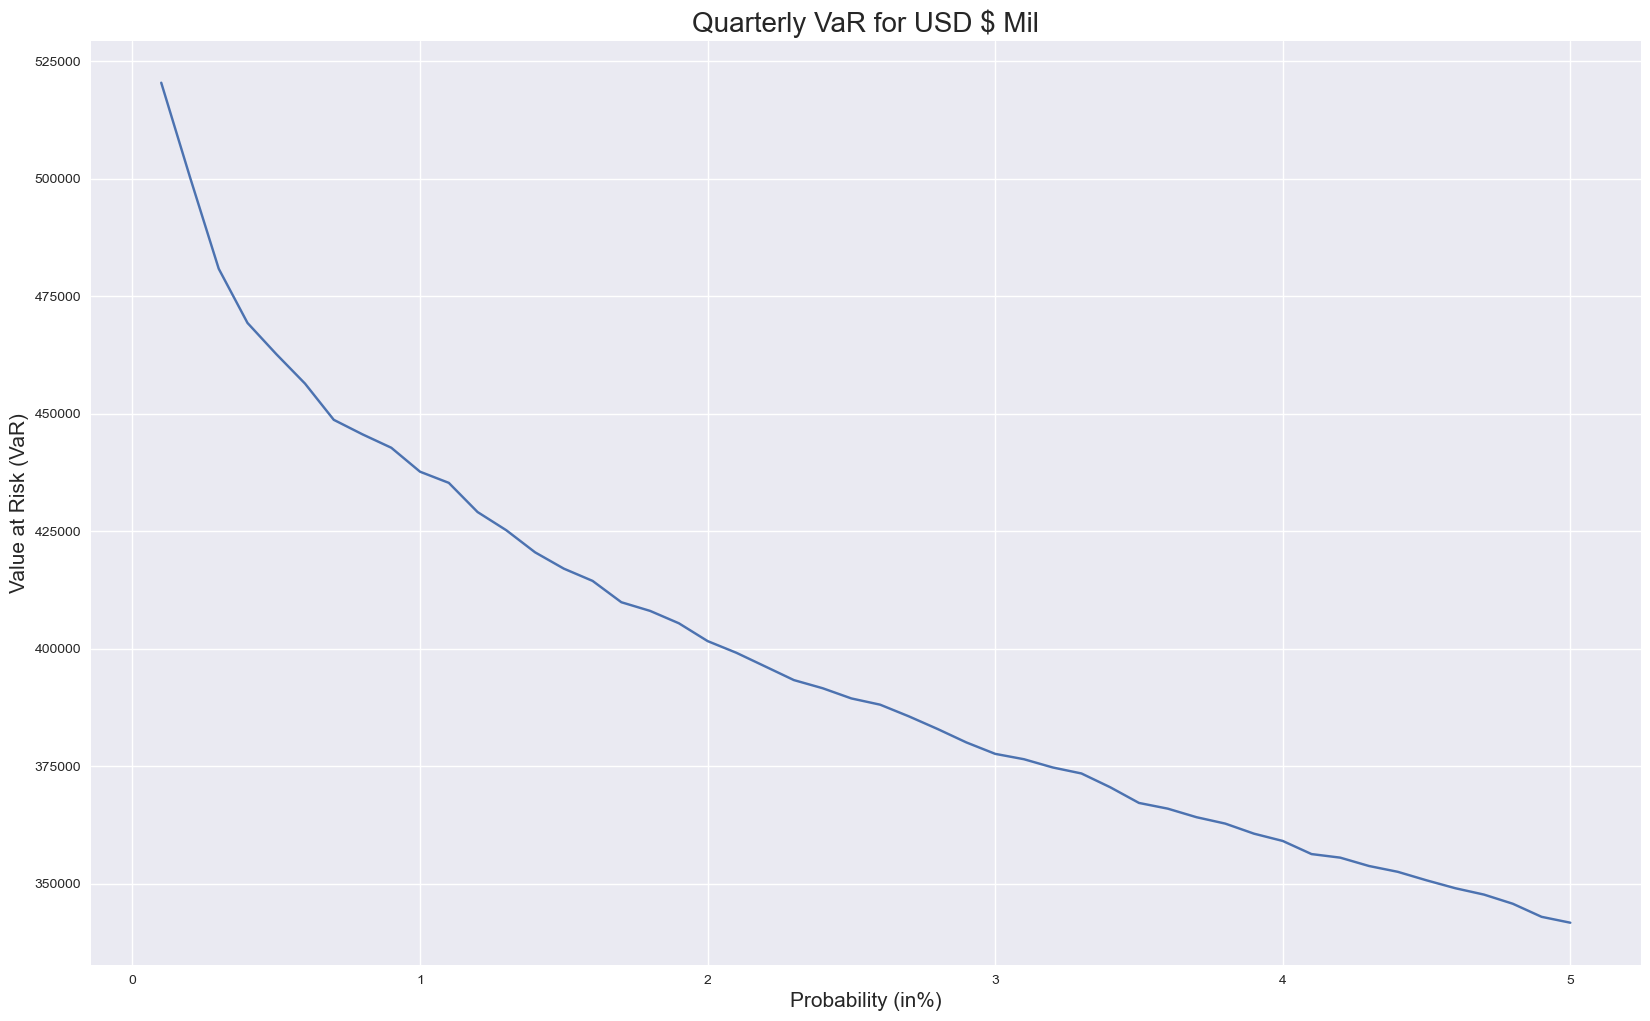

In [67]:
plt.figure(figsize=(20, 12))
plt.plot(np.linspace(0.1, 5, 50), var_p2)
plt.title("1% VaR for USD $1 Mil")
plt.title("Quarterly VaR for USD $ Mil", fontsize=20)
plt.xlabel("Probability (in%)", fontsize=15)
plt.ylabel("Value at Risk (VaR)", fontsize=15)
#plt.grid(True)
plt.show()